In [ ]:
# Imports used in Normalizing Flow notebook
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

from astropy.io import fits
import sys
import pandas as pd

In [ ]:
import glob
from skimage.transform import resize

In [ ]:
# Tentative imports for autoencoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [ ]:
def updateHeader(header):
    header['NAXIS1'] = 100
    header['NAXIS2'] = 100  
    header['CRPIX1'] = 50  
    header['CRPIX2'] = 50  
    return header
def normalizeIm(image):
    dn, med, up = np.percentile(image.flatten(), [.5,50,99])
    res = (image-med)/(up-dn)
    res[res>1] = 1
    res[res<0] = 0
    return res

In [ ]:
def resize_images(filepath):
  flist = glob.glob(filepath+'*.fits')

  filesizes = []
  for f in flist:
      filesizes.append(fits.open(f)[0].shape)
      
  filesizes = np.array(filesizes)

  for fs,f in zip(filesizes, flist):
      new_name = filepath+'resized/'+f.split('/')[-1].replace('.fits', '_resized.fits')
      if fs[0]>100:
          im_hdul = fits.HDUList()
          orig = fits.open(f)[0]
          resized = resize(orig.data, (100, 100))
          im_hdul.append(fits.PrimaryHDU(normalizeIm(resized), updateHeader(orig.header.copy())))
          im_hdul.writeto(new_name, overwrite=True)
      elif fs[0]==100:
          im_hdul = fits.HDUList()
          orig = fits.open(f)[0]
          im_hdul.append(fits.PrimaryHDU(normalizeIm(orig.data), orig.header.copy()))
          im_hdul.writeto(new_name, overwrite=True)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
galaxies_path = "drive/MyDrive/UCI/Research/GALFIT/scripting/galaxies/"
#! ls drive/MyDrive/UCI/Research/GALFIT/scripting/galaxies

In [ ]:
# Autoencoder variables
INPUT_SIZE      = 100
LATENT_SIZE     = 256

In [ ]:
# Normalizing Flow variables
INPUT_SIZE_NF      = 16
LATENT_SIZE_NF     = 6

# set number of layers and dimensionality of data
NLAYERS = 4
SIZE    = 4

In [ ]:
# Function to read in images
def read_in_galaxies(filepath):
  
  image_data = {}
  for i in os.listdir(filepath):
    with fits.open(os.path.join(filepath, i)) as image:
      if i.endswith('.fits'): image_data[i.rstrip('.fits')] = image[0].data # Just to be safe

  return image_data


In [ ]:
# resize_images(galaxies_path)

In [ ]:
galaxy_dict = read_in_galaxies(os.path.join(galaxies_path, "resized/"))

In [ ]:
with open(os.path.join(galaxies_path, "galaxy_info.csv"), 'w+') as ginfo:
  ginfo.write("galaxy_name,quality\n")
  for i in os.listdir(galaxies_path):
    ginfo.write(f"{i},{np.random.randint(0,1)}\n")

In [ ]:
galaxies_df = pd.read_csv(os.path.join(galaxies_path, "galaxy_info.csv"))
print(len(galaxies_df))

902


In [ ]:
galaxies_df = pd.read_csv(os.path.join(galaxies_path, "galaxy_info.csv"))


labels = np.array(galaxies_df['quality'])

images = np.array(list(galaxy_dict.values()), dtype = np.float32)
images = torch.tensor(images)
labels = torch.tensor(labels)
#images = images[:,::6,::6,1]

#Plot an example image here
# for i in images:
#   plt.imshow(i, vmin = 0, vmax = 1)
#   plt.figure()

#Flatten images here
images_flat = images.reshape(len(images),-1)
print(np.shape(images_flat))

torch.Size([758, 10000])


In [ ]:
images_train, images_test = train_test_split(
    images_flat, test_size=0.33, random_state=42)

In [ ]:
class Autoencoder(torch.nn.Module):
      # this defines the model
        def __init__(self, input_size, hidden_size, hidden_inner, encoded_size):
            super(Autoencoder, self).__init__()
            print(input_size,hidden_size,encoded_size)
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.encoded_size = encoded_size
            self.hidden_inner = hidden_inner
            self.hiddenlayer1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.hiddenlayer2 = torch.nn.Linear(self.hidden_size, self.hidden_inner)
            self.encodedlayer = torch.nn.Linear(self.hidden_inner, self.encoded_size)
            self.hiddenlayer3 = torch.nn.Linear(self.encoded_size, self.hidden_inner)
            self.hiddenlayer4 = torch.nn.Linear(self.hidden_inner, self.hidden_size)
            self.outputlayer = torch.nn.Linear(self.hidden_size, self.input_size)
            # some nonlinear options
            self.sigmoid = torch.nn.Sigmoid()
            self.softmax = torch.nn.Softmax()
            self.relu = torch.nn.ReLU()
        def forward(self, x):
            layer1 = self.hiddenlayer1(x)
            activation1 = self.relu(layer1)
            layer2 = self.hiddenlayer2(activation1)
            activation2 = self.relu(layer2)
            layer3 = self.encodedlayer(activation2)
            activation3 = self.relu(layer3)
            layer4 = self.hiddenlayer3(activation3)
            activation4 = self.relu(layer4)
            layer5 = self.hiddenlayer4(activation4)
            activation5 = self.relu(layer5)
            layer6 = self.outputlayer(activation5)
            output = self.relu(layer6)
            return output, layer3

In [ ]:
# train the model
def train_model(training_data,test_data, model):
  # define the optimization
  criterion = torch.nn.MSELoss()

  # Choose between these two optimizers
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay=1e-6)

  for epoch in range(200):
    # clear the gradient
    optimizer.zero_grad()
    # compute the model output
    myoutput, encodings_train = model(training_data)
    # calculate loss
    loss = criterion(myoutput, training_data)
    # credit assignment
    loss.backward()
    # update model weights
    optimizer.step()
    print(epoch,loss)
    # STUDENTS ADD THIS PART
    output_test, encodings_test = model(test_data)
    loss_test = criterion(output_test, test_data)
    plt.plot(epoch,loss.detach().numpy(),'ko', label = 'train')
    plt.plot(epoch,loss_test.detach().numpy(),'ro', label = 'test')
  #plt.legend()
  plt.show()


10000 50 10
0 tensor(0.0306, grad_fn=<MseLossBackward0>)
1 tensor(0.0295, grad_fn=<MseLossBackward0>)
2 tensor(0.0286, grad_fn=<MseLossBackward0>)
3 tensor(0.0276, grad_fn=<MseLossBackward0>)
4 tensor(0.0263, grad_fn=<MseLossBackward0>)
5 tensor(0.0248, grad_fn=<MseLossBackward0>)
6 tensor(0.0231, grad_fn=<MseLossBackward0>)
7 tensor(0.0215, grad_fn=<MseLossBackward0>)
8 tensor(0.0201, grad_fn=<MseLossBackward0>)
9 tensor(0.0189, grad_fn=<MseLossBackward0>)
10 tensor(0.0178, grad_fn=<MseLossBackward0>)
11 tensor(0.0171, grad_fn=<MseLossBackward0>)
12 tensor(0.0166, grad_fn=<MseLossBackward0>)
13 tensor(0.0161, grad_fn=<MseLossBackward0>)
14 tensor(0.0159, grad_fn=<MseLossBackward0>)
15 tensor(0.0157, grad_fn=<MseLossBackward0>)
16 tensor(0.0155, grad_fn=<MseLossBackward0>)
17 tensor(0.0154, grad_fn=<MseLossBackward0>)
18 tensor(0.0153, grad_fn=<MseLossBackward0>)
19 tensor(0.0152, grad_fn=<MseLossBackward0>)
20 tensor(0.0150, grad_fn=<MseLossBackward0>)
21 tensor(0.0149, grad_fn=<MseLo

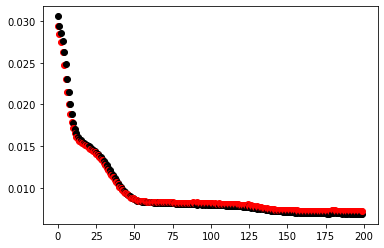

In [ ]:
model = Autoencoder(np.shape(images_train[0])[0],50,50,10)
train_model(images_train, images_test, model)

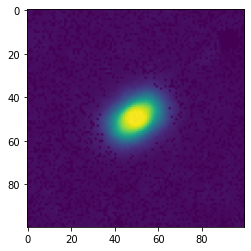

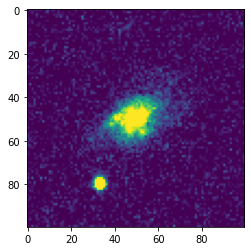

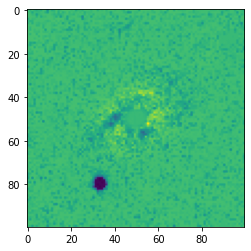

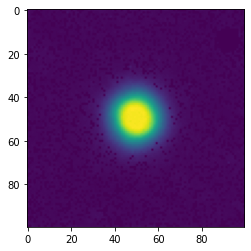

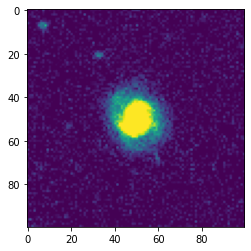

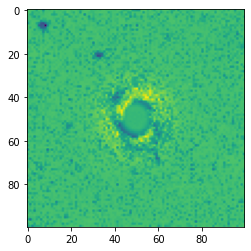

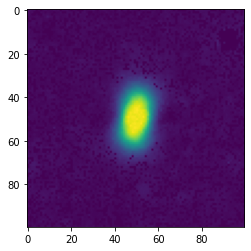

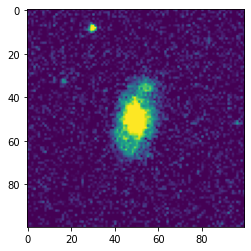

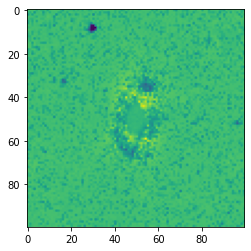

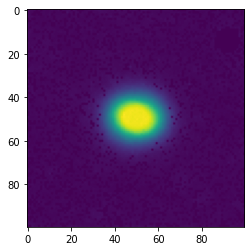

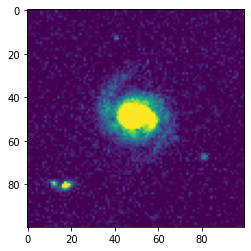

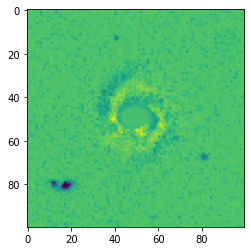

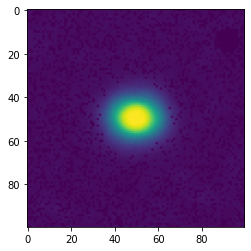

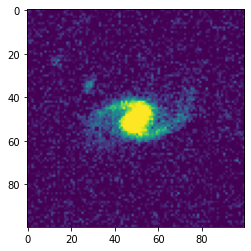

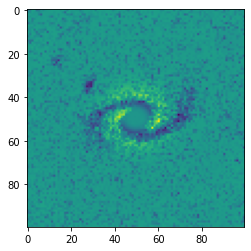

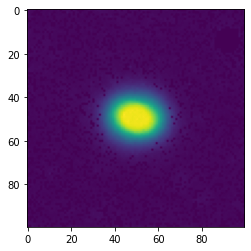

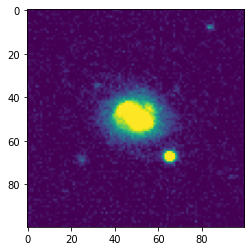

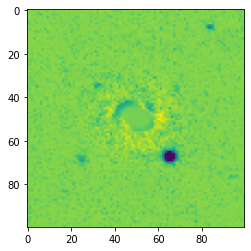

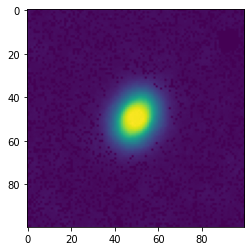

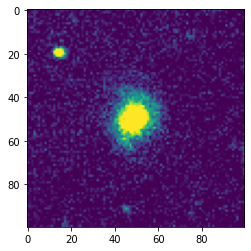

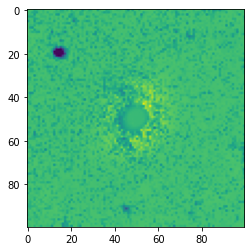

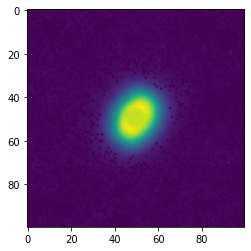

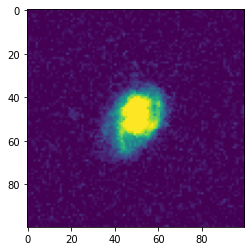

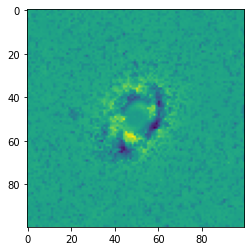

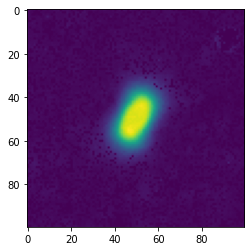

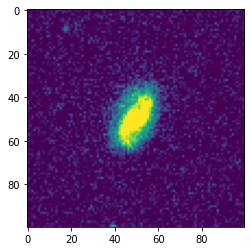

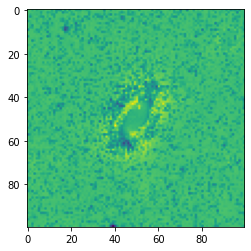

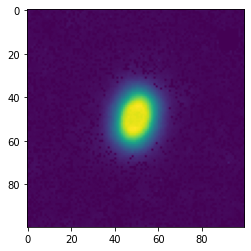

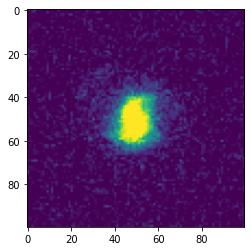

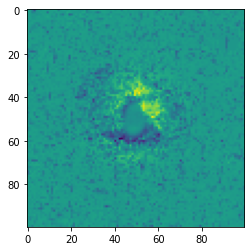

In [ ]:
yhat, test_encodings = model(images_test)
yhat = yhat.detach().numpy()
yhat = np.reshape(yhat,(len(images_test),100,100))
image_reshaped = np.reshape(images_test,(len(images_test),100,100))
# rand_int = int(np.random.choice(np.arange(len(yhat))))
for i, im in enumerate(yhat[:10]):

  plt.imshow(im)
  plt.show()

  plt.imshow(image_reshaped[i])
  plt.show()

  plt.imshow(im - image_reshaped[i].detach().numpy())
  plt.show()